_Restarting vtk-m-env (Python 3.9.23)..._

Restarted vtk-m-env (Python 3.9.23)

Connected to vtk-m-env (Python 3.9.23)

VTK Version: 9.4.2
OpenGL2 Enabled: True


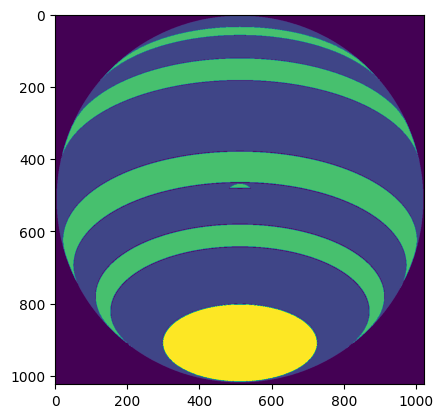

In [ ]:
"""
Created on April 1 2025

Upgrade from AtmosphereGenerator.py:
- significant improvement in speed via vectorization of routines
- gpu acceleration with pyvista but mainly cpu computation
- added multi-pressure capability

@author: nguyendat
"""
# IMPORT LIBRARIES
import h5py
import pickle
import os
# =============================================================================
# Enable vtk GPU-backend 
import vtk
# Set debug flags for VTK/OpenGL
os.environ["VTK_DEBUG_OPENGL"] = "1"
os.environ["VTK_REPORT_OPENGL_ERRORS"] = "1"
print("VTK Version:", vtk.vtkVersion.GetVTKVersion())
print("OpenGL2 Enabled:", hasattr(vtk, 'vtkOpenGLRenderWindow'))
# =============================================================================
import pyvista as pv
import cv2
import tqdm
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import warnings
from scipy.ndimage import gaussian_filter
import pandas as pd
from sklearn.decomposition import PCA
from datetime import datetime
import imageio
from PIL import Image
from sklearn.cluster import KMeans
# =============================================================================
### Path management
import os
from os.path import join
folderarray = os.path.abspath('').split('/')
homedir = '/'
for i in range(len(folderarray)):
   homedir = join(homedir, folderarray[i])
plotPath = join(homedir, 'plot/')
# ==============================================================================
# Handles spherical mesh generation and geometric calculations
# =============================================================================
class SphericalMesh:
    def __init__(self, resolution=400, radius=1):
        self.radius = radius
        self.resolution = resolution
        self.phi, self.theta = None, None
        self.x, self.y, self.z = None, None, None
        self.generate_mesh()
        
    def generate_mesh(self):
        """Create spherical grid coordinates"""
        phi = np.linspace(0, np.pi, self.resolution)
        # phi = np.arccos(np.linspace(1, -1, self.resolution))  # Cosine spacing
        theta = np.linspace(0, 2*np.pi, self.resolution)
        self.phi, self.theta = np.meshgrid(phi, theta)
        
        self.x = self.radius * np.sin(self.phi) * np.cos(self.theta)
        self.y = self.radius * np.sin(self.phi) * np.sin(self.theta)
        self.z = self.radius * np.cos(self.phi)
    
    @property
    def shape(self):
        return self.x.shape
# ==============================================================================
# Manage config and parameters
# =============================================================================
class TimeConfig:
    """Centralized management of temporal parameters"""
    def __init__(self, t0=0, t1=60, frames=60):
        """
        Args:
            t0: Start time (hours)
            t1: End time (hours)
            frames: Number of animation frames
        """
        self.t0 = t0
        self.t1 = t1
        self.frames = frames
        
        # Derived properties
        self.time_array = np.linspace(t0, t1, frames)
        self.dt = (t1 - t0) / frames  # Time step
        
    def __repr__(self):
        return f"TimeConfig(t0={self.t0}, t1={self.t1}, frames={self.frames})"
# =============================================================================
class AtmosphericConfig:
    """Combined atmospheric and temporal configuration"""
    def __init__(self, 
                 band_config: list,
                 modu_config: str,
                 modelname: str,
                 time_config: TimeConfig,
                 Fband: float = 0.6,
                 Fband_var: float = 0.05,
                 Fambient: float  = 0.5,
                 Fambient_var: float = 0.00,
                 Fpolar: float  = 0.7,
                 Fpolar_var: float = 0.05,
                 Pband: float  = 5.0,
                 Ppol: float  = 60.0,
                 speckey: dict = None):
        """
        Args:
            band_config: Atmospheric band parameters
            modu_config: Modulation type ('polarStatic' etc)
            modelname: Simulation identifier
            time_config: TimeConfig object
            Fambient/band/pole: Ambient/band/pole base contrast value (amp)
            Fambient_var/band_var/polar_var: Variability value (variab) 
            Pband/pole: Band/pole period (in hours)
            speckey: Spectral value mapping
        """
        self.band_config = band_config
        self.modu_config = modu_config
        self.modelname = modelname
        self.time_config = time_config
        # Base contrast values
        self.Fambient = Fambient
        self.Fambient_var = Fambient_var
        self.Fband = Fband
        self.Fband_var = Fband_var
        self.Fpolar = Fpolar
        self.Fpolar_var = Fpolar_var
        # Periods in hours
        self.Pband = Pband
        self.Ppol = Ppol
        self.speckey = speckey or {'BG':0, 'A': 0.25, 'B': 0.58, 'P': 0.75}
        
        self._validate_config()

    def _validate_config(self):
        """Sanity checks for configuration"""
        if not isinstance(self.time_config, TimeConfig):
            raise TypeError("time_config must be TimeConfig instance")
        
        required_band_keys = ['lat2', 'lat1', 'amp', 'typ', 'phase', 'period', 'variab']
        for band in self.band_config:
            if len(band) != len(required_band_keys):
                raise ValueError("Invalid band configuration")
# ==============================================================================
# Core atmospheric simulation logic
# =============================================================================
class AtmosphericModel:
    def __init__(self, mesh, config):
        """
        Args:
            mesh: SphericalMesh object (provides x, y, z coordinates)
            config: AtmosphericConfig object (simulation parameters)
            speckey: Dict mapping region types to spectral values
        """
        self.mesh = mesh
        self.config = config
        self.speckey = config.speckey
        
        # Derived properties from mesh
        self.xsize, self.ysize = self.mesh.shape
        self.xx, self.yy = np.meshgrid(np.arange(self.xsize), np.arange(self.ysize), indexing='ij')
        
        # Precompute latitude grid (vectorized)
        self.lat_grid = np.abs(self.yy - 90) / 180 * self.ysize  # From lat() function

    def generate_specmap(self):
        """
        Generate a spectral mask based on the speckey configuration.
        
        Returns:
            sm: Spectral mask array with shape (xsize, ysize)
        """
        sm = np.full((self.xsize, self.ysize), self.speckey['A'], dtype=np.float32)

        for group in self.config.band_config:
            lat2, lat1, amp, typ, phase, period, variab = group
            lat_px1 = self._lat_px(lat1)
            lat_px2 = self._lat_px(lat2)
            
            # Vectorized latitude mask
            mask = (self.yy >= lat_px2) & (self.yy <= lat_px1)
            sm[mask] = self.speckey[typ.upper()]
        
        return sm

    def generate_atmosphere(self, t, spec=False):
        """
        Generate atmospheric map at time `t`.
        
        Args:
            t: Current timestep
            spec: If True, return spectral map alongside flux map
            
        Returns:
            im (flux map) or (im, sm) tuple if spec=True
        """
        # Initialize base maps
        im = np.full((self.xsize, self.ysize), self.config.Fambient, dtype=np.float32)
        sm = np.full_like(im, self.speckey['A']) if spec else None
        
        # Apply all configured atmospheric features
        for group in self.config.band_config:
            lat2, lat1, amp, typ, phase, period, variab = group
            lat_px1 = self._lat_px(lat1)
            lat_px2 = self._lat_px(lat2)
            
            # Vectorized latitude mask
            mask = (self.yy >= lat_px2) & (self.yy <= lat_px1)
            im[mask] = amp
            
            if typ.upper() == 'B':  # Band
                im = self._apply_planetary_wave(im, mask, t, amp, phase, period, variab)
                
            elif typ.upper() == 'P':  # Polar
                im = self._apply_polar_effect(im, mask, t, amp, phase, period, variab)
                
            if spec:
                sm[mask] = self.speckey[typ.upper()]
                
        # Apply vortices if needed
        if self.config.modu_config in ['polarStatic', 'polarDynamic']:
            im = self._apply_vortices(im, t, self.config.modu_config)
            
        return (im, sm) if spec else im
    
    def _lat_px(self, lat_deg):
        """Convert latitude to pixel coordinate (vectorized)"""
        return np.abs(lat_deg - 90) / 180 * self.ysize
    
    def _apply_planetary_wave(self, im, mask, t, amp, phase, period, variab):
        """Vectorized planetary wave implementation"""
        # Spatial frequency (1/wavelength)
        w = self.xsize  # Full circumference resolution
        sine_wave = variab * np.sin(
            2 * np.pi / w * (self.xx + (t / period) * w) + phase * np.pi / 180
        )
        im[mask] += sine_wave[mask]
        return im
    
    def _apply_polar_effect(self, im, mask, t, amp, phase, period, variab):
        """Polar cap modulation (vectorized)"""
        
        flux = variab * np.sin(2 * np.pi / period * t + phase * np.pi / 180)
        im[mask] += flux
        return im
    
    # [Deprecated] : vectorized vortices implementation
    def _apply_vortices(self, im, t, modu_config):
        """Vectorized vortices implementation"""
        # Get polar regions from config
        polar_groups = [g for g in self.config.band_config if g[3].upper() == 'P']
        
        for group in polar_groups:
            lat2, lat1, *_ = group
            # im = self._circle_vortice_vectorized(im, lat1, lat2, t, group, modu_config)  # Pass full group
            
        return im
    
    def _circle_vortice_vectorized(self, im, lat1, lat2, t, group, modu_config):
        """Vectorized vortex generator (corrected)"""
        # Sort latitudes (lat1 > lat2)
        lat1, lat2 = sorted([lat1, lat2], reverse=True)
        center_lat = (lat1 + lat2) / 2
        center_px = self._lat_px(center_lat)
        lat_px1 = self._lat_px(lat1)
        lat_px2 = self._lat_px(lat2)
        
        # Vortex properties (from config)
        radius_frac = 0.3
        a, b = 0.70, 0.25  # Ellipse axes
        # Make sure area_cap doesn't become negative 
        # when lat1 < lat2 (e.g., southern hemisphere).
        area_cap = 2 * np.pi * abs(np.sin(np.radians(lat1)) - np.sin(np.radians(lat2)))
        r_vortice = np.sqrt(radius_frac * area_cap) * (self.xsize / np.pi)
        ar, br = a * r_vortice, b * r_vortice
        
        # Time-dependent longitudinal positions (corrected drift)
        rotation_period = group[5]
        long_positions = self._equidistant_longitudes(t, rotation_period)

        # Latitude mask
        lat_mask = (self.yy <= lat_px2) & (self.yy >= lat_px1)
        
        # Amplitude from polar region
        amplitude = im[int(self.xsize / 2), self.ysize - 1]  # Central pixel
        
        # Generate grid
        # xx, yy = np.meshgrid(np.arange(self.xsize), np.arange(self.ysize), indexing='ij')
        
        if modu_config == 'polarDynamic':
            phase_values = np.array(2*[0, -2, 5, -4, 8, 2, 4, -6, -8])  # Phase offsets
            variableflux = 0.2 * np.sin(2 * np.pi / rotation_period * t - phase_values[i % len(phase_values)])
        elif modu_config == 'polarStatic':
            phase_values = np.array(2*[0, 0, 0, 0, 0, 0, 0, 0, 0])  # Phase offsets
            variableflux = 0
        amplitude = 0.25*im[int(self.xsize / 2), self.ysize - 1]  # Dynamic amplitude

        # Time-dependent positions (correct drift)
        rotation_period = group[5]
        long_positions = self._equidistant_longitudes(t, rotation_period)
        
        for i, long_px in enumerate(long_positions):
            xi = int(long_px)
            ellipse_mask = (
                ((self.xx - xi) ** 2 / ar ** 2) + 
                ((self.yy - center_px) ** 2 / br ** 2)
            ) <= 1
            
            im[ellipse_mask & lat_mask] += amplitude + variableflux  # Dynamic adjustment
        return im
    
    def _long_px(self, long_deg):
        """Convert longitude (degrees) to pixel coordinate."""
        return (long_deg / 360) * self.xsize  # Match original code's `long()` function

    def _equidistant_longitudes(self, t, rotation_period):
        """Calculate vortex positions with correct degree-to-pixel conversion."""
        n_vortices = 5
        base_pos_deg = np.linspace(0, 360, n_vortices + 1)[:-1]  # Degrees (0-360)
        base_pos = self._long_px(base_pos_deg)  # Convert to pixels
        drift = ((-t % rotation_period) / rotation_period) * self.xsize
        long_positions = (base_pos + drift) % self.xsize  # Overflow

        # Wrap around logic: no empty edges 
        dxCen = np.diff(base_pos)[0]
        if long_positions.min() <= base_pos.min():
            long_positions = np.append(long_positions, long_positions.max() + dxCen)
        if long_positions.max() >= base_pos.max():
            long_positions = np.append(long_positions, long_positions.min() - dxCen)   

        return long_positions
    
# ==============================================================================
# Visualization of atmospheric data using PyVista
# =============================================================================
class AtmosphereVisualizer:
    def __init__(self, mesh, speckey, inclination=0):
        self.mesh = mesh
        self.inclination = inclination
        self.plotter = self._create_plotter()
        self.speckey = speckey

    def _create_plotter(self):
        """Configure PyVista plotter"""
        """Configure PyVista plotter with proper camera setup"""
        plotter = pv.Plotter(
            off_screen=True,
            window_size=(1024, 1024),  # Explicit size helps consistency
            lighting="three lights"  # Better depth perception
        )
        plotter.camera.SetParallelProjection(True) # Set parallel projection for photometry
        plotter.background_color = 'black' # Set background color to black
        return plotter

    def im_posterize(self, img, tol=15, n_clusters=4, min_count=20):
        """Posterize grayscale image using KMeans clustering and remap to speckey values"""
        target_values = np.array(list(self.speckey.values()), dtype=np.uint8)

        # Flatten to 1D array of intensities
        pixels = img.ravel()

        # Filter out rare/noisy intensities
        unique, counts = np.unique(pixels, return_counts=True)
        valid = unique[counts >= min_count]
        filtered_pixels = pixels[np.isin(pixels, valid)]

        if filtered_pixels.size == 0:
            return np.zeros_like(img, dtype=np.uint8), {}

        # Run KMeans on filtered values
        X = filtered_pixels.reshape(-1, 1)
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        kmeans.fit(X)

        # Round centroids to nearest integers and sort them
        centroids = np.sort(np.rint(kmeans.cluster_centers_.flatten()).astype(int))

        # Map sorted centroids to speckey values (smallest->0, next->80, etc.)
        centroid_map = dict(zip(centroids, target_values))

        # Create output image initialized to 0
        output_img = np.zeros_like(img, dtype=np.uint8)

        # Apply mapping: within tolerance of centroid -> mapped speckey value
        for c, mapped_val in centroid_map.items():
            mask = np.abs(img.astype(int) - int(c)) <= tol
            output_img[mask] = mapped_val

        return output_img, centroid_map

    def render_specmask(self, specmap, levels=4, color_lim=[0.0, 1.0]):
        """Render spectral mask with full sphere visible"""
        self.plotter.clear()
        grid = pv.StructuredGrid(self.mesh.x, self.mesh.y, self.mesh.z)
        grid.point_data['scalars'] = specmap.ravel(order='F')
        self.plotter.add_mesh(grid, show_scalar_bar=False,
                              cmap='viridis')
        
        # Set camera to look at the sphere orthographically
        self.plotter.camera.position = (0, 0, 1)  # Distance irrelevant; kept at 1 for syntax
        self.plotter.camera.focal_point = (0, 0, 0)  # Center of the sphere
        self.plotter.camera.up = (0, 1, 0)  # Keep north at the top
        
        # Apply inclination adjustment
        self.plotter.camera.elevation = self.inclination

        # Fine-tune the field of view with parallel_scale
        self.plotter.camera.parallel_scale = 1.01  # Match this to your desired zoom
        # Return black and white
        screenshot = self.plotter.screenshot()
        grayscale = np.dot(screenshot[..., :3], [0.2989, 0.5870, 0.1140])
        # posterize
        specmask = self.im_posterize(grayscale, tol=20)

        return specmask

    def render_frame(self, atmospheric_data, color_lim=[0.0, 1.0]):
        """Render single timestep with full sphere visible"""
        self.plotter.clear()
        grid = pv.StructuredGrid(self.mesh.x, self.mesh.y, self.mesh.z)
        grid.point_data['scalars'] = atmospheric_data.ravel(order='F')
        self.plotter.add_mesh(grid, cmap='inferno', show_scalar_bar=False,
                              clim=color_lim
        )
        
        # Set camera to look at the sphere orthographically
        self.plotter.camera.position = (0, 0, 1)  # Distance irrelevant; kept at 1 for syntax
        self.plotter.camera.focal_point = (0, 0, 0)  # Center of the sphere
        self.plotter.camera.up = (0, 1, 0)  # Keep north at the top
        
        # Apply inclination adjustment
        self.plotter.camera.elevation = self.inclination

        # Fine-tune the field of view with parallel_scale
        self.plotter.camera.parallel_scale = 1.01  # Match this to your desired zoom

        return self.plotter.screenshot()
# ==============================================================================
# Run the simulation and visualization
#===============================================================================
class SimulationRunner:
    def __init__(self, config, inclinations, base_path='output'):
        self.mesh = SphericalMesh()
        self.config = config  # Directly use the provided AtmosphericConfig instance
        self.inclinations = inclinations

        # Get current script directory and create full output path
        current_dir = os.path.dirname(os.path.abspath(__file__))
        self.base_path = os.path.join(current_dir, base_path)
        
        # Create directory if it doesn't exist
        os.makedirs(self.base_path, exist_ok=True)

        self.results = {}
    
    def run_simulation(self, t0=0, t1=60, frames=60, color_lim=[0.0, 1.0]):
        time_array = np.linspace(t0, t1, frames)
        
        for inclin in self.inclinations:
            visualizer = AtmosphereVisualizer(self.mesh, self.config.speckey, inclin)
            model = AtmosphericModel(self.mesh, self.config)
            
            results = {
                'gray_array': [],
                'metadata': self.config.__dict__,
                'specmask': None,
                'centroids_specmask': None
            }
            
            for t in time_array:
                atmospheric_data = model.generate_atmosphere(t)
                specmap = model.generate_specmap()
                frame = visualizer.render_frame(atmospheric_data, color_lim=color_lim)
                results['gray_array'].append(frame)
            
            specmask, centroids = visualizer.render_specmask(specmap, color_lim=color_lim)
            results['specmask'] = specmask
            results['centroids_specmask'] = centroids

            self.results[inclin] = results

# ============================================================================
# Input output handler and data management
# ============================================================================
    def save_simulation(self, prefix):
        results = self.results
        output_path = os.path.join(self.base_path, f'{prefix}.h5')
        with h5py.File(output_path, 'w') as f:
            for inclin, data in results.items():
                f.create_dataset(f'{inclin}/gray_array', data=np.array(data['gray_array']))
                f.create_dataset(f'{inclin}/specmask', data=data['specmask'])
                f.create_dataset(f'{inclin}/metadata', data=str(data['metadata']))

    # ===================================
    # Convert gray_array to video
    # ===================================
    @staticmethod
    def save_video_from_array(gray_array, filepath, fps=30):
        # Ensure frames are uint8
        frames_uint8 = (np.clip(gray_array, 0, 1) * 255).astype(np.uint8) \
            if gray_array.dtype != np.uint8 else gray_array

        # Convert RGB to BGR for OpenCV
        frames_bgr = [cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) for frame in frames_uint8]

        height, width, _ = frames_bgr[0].shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(filepath, fourcc, fps, (width, height))

        if not out.isOpened():
            raise RuntimeError(f"Failed to open VideoWriter: {filepath}")

        for frame in frames_bgr:
            out.write(frame)
        out.release()

    def create_videos_from_h5(self, prefix, fps=30):
        """
        Create grayscale videos for each inclination stored in an HDF5 file.
        """
        h5_file_path = os.path.join(self.base_path, f'{prefix}.h5')
        base_name = os.path.splitext(os.path.basename(h5_file_path))[0]
        output_folder = os.path.join(self.base_path, f"{base_name}_video")
        os.makedirs(output_folder, exist_ok=True)

        with h5py.File(h5_file_path, 'r') as f:
            for inclin in f.keys():
                gray_array = f[f'{inclin}/gray_array'][:]
                video_path = os.path.join(output_folder, f"{base_name}_inclin={inclin}.mp4")
                self.save_video_from_array(gray_array, video_path, fps=fps)

# ==============================================================================
# Light curve generation and plotting
# ==============================================================================
class LightCurveGenerator:
    def __init__(self, results):
        """
        Args:
            results: Simulation results dictionary from SimulationRunner
        """
        self.results = results

# ==============================================================================
# Set up configurations and test call
# =============================================================================

if __name__ == "__main__":
    
    runName = 'test_i60'

    # Set up band_config: latitudinal features
    Ppol, Pband = 60, 5  # Periods in hours
    Fpolar, Fband, Fambient = 1, 1, 1 # amp
    Fpolar_var, Fband_var, Fambient_var = 0.15, 0.15, 0.00 # variab
    # variability: amp + variab * sin(...)
    bandConfig = [
        # [lat2, lat1, amplitude, type, phase, period]
        [90, 65, Fpolar, 'P', 0, Ppol, Fpolar_var],
        [45, 38., Fband, 'B', 10, Pband/2, Fband_var],
        [25, 15, Fband, 'B', 150, Pband, Fband_var], 
        [-10, -20, Fband, 'B', -26, Pband, Fband_var],
        [-33, -40, Fband, 'B', 135, Pband/2, Fband_var],
        [-65, -90, Fpolar, 'P', 0, Ppol, Fpolar_var]
    ]

    # Set up atmosphere config: the rest of the simulation
    atmo_config = AtmosphericConfig(
        band_config=bandConfig,  # This is your band configuration list
        modu_config='polarStatic',
        modelname='production1',
        time_config=TimeConfig(t0=0, t1=60, frames=60),
        Fambient=Fambient,  # This will be accessible as config.Fambient
        Fband=Fband,
        Fpolar=Fpolar,
        speckey={'BG':0, 'A': 50, 'B': 170, 'P': 240}
    )

    # Set up the spherical mesh, initialization
    mesh = SphericalMesh(resolution=200)
    model = AtmosphericModel(mesh, atmo_config)

    incli_array = [60] # List of inclinations to simulate
    # Set up the inclination configuration
    runner = SimulationRunner(
        config=atmo_config,
        inclinations=incli_array
    )

    # Run the simulation for a specific time range and number of frames
    runner.run_simulation(t0=0, t1=60, frames=60, color_lim=[0.5, 1.5]) 
    # color_lim sets the color range for spatial visualization

    # Save the simulation results
    runner.save_simulation(runName)

    # Save a video of simulation results
    # runner.create_videos_from_h5(runName, fps=6)

    # Test the output
    def plot_frames(h5_path, inclination, t=0, handle='gray'):
        with h5py.File(h5_path, 'r') as f:
            if handle == 'gray':
                data = f[f'{inclination}/gray_array'][t]  # First frame
                plt.imshow(data, vmin=0.0, vmax=1.0, cmap='inferno')
            elif handle == 'spec':
                data = f[f'{inclination}/specmask']
                plt.imshow(data, cmap='viridis')
            plt.show()

    filepath = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'output', runName+'.h5')
    for inc in incli_array:
        # for t in range(60):
            # plot_frames(filepath, inclination=inc, t=t, handle='gray')
        plot_frames(filepath, inclination=inc, handle='spec')